<a href="https://colab.research.google.com/github/SarthakJha-IITMandi/DS3-2021/blob/main/PRA2_B20317.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Including all required libraries

In [1]:
import librosa
import csv
import os
import numpy as np
import pandas as pd
# from utils import compute_vad  # GMM based Voice activity detection program
from sklearn.mixture import GaussianMixture
import pandas as pd
import glob
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# train = pd.read_csv("/content/drive/MyDrive/CSV_Combined/asm/PB_train/file_combined.csv")
# print(train)

### Feature extraction code for converting wav files to csv

In [4]:
###############################################################################
# source_path="write path to source folder" # path to source folder containing the wav files
# destination_path = "write path to destination folder" # path to destination folder where csv file are to be stored

n_fft = 320  # window length of stft
hop_length = 160  # hop length of stft (50% overlap)
n_mfcc = 13  # number of mfcc to be extracted
target_sr = 8000  # resampling the wav file to trageted sample rate
##################################################################################
langs = ["asm", "ben", "eng", "guj", "hin", "kan", "mal", "mar", "odi", "pun", "tam", "tel"]
paths_x = ["PB_test", "PB_train", "YT_test"]

to_convert = False
if to_convert:
  
  for lang in range(len(langs)):
      for path in range(len(paths_x)):
        source_path = (
            "/home/sarthak/IIT Mandi/DS403/PR_A2-20221119T053251Z-001/PR_A2"
            + "/{}".format(langs[lang])
            + "/{}".format(paths_X[path])
        )

        os.chdir(source_path)
        for file in os.listdir(source_path):
            if file.endswith("wav"):
                audio_file = file

                signal, sr = librosa.load(audio_file)  # loading the wav file

                signal_8k = librosa.resample(
                    signal, orig_sr=sr, target_sr=target_sr
                )  # resampling the audio file at 8KHz (optional step, may be ignored)

                mfccs = librosa.feature.mfcc(
                    y=signal_8k,
                    n_fft=n_fft,
                    hop_length=hop_length,
                    n_mfcc=n_mfcc,
                    sr=target_sr,
                    center=False,
                )  # mfcc feacture extractation

                delta_mfccs = librosa.feature.delta(
                    mfccs
                )  # computation of first order delta over the mfcc feature

                delta2_mfccs = librosa.feature.delta(
                    mfccs, order=2
                )  # computation of second order delta over the mfcc feature

                comprehensive_mfccs = np.concatenate(
                    (mfccs, delta_mfccs, delta2_mfccs)
                )  # concatenating mfcc, delta and delta-delta features

                data = comprehensive_mfccs.T  # transposing the concatenated feature

                vad = compute_vad(
                    signal_8k, win_length=n_fft, win_overlap=hop_length
                )  # voice activity detection computation

                fn = os.path.splitext(file)[0]  # wav file name extracting from path
                print("creating {}.csv".format(fn))

                des_path = (
                    "/home/sarthak/IIT Mandi/DS403/PR_A2-20221119T053251Z-001/csv_files"
                    + "/{}".format(langs[lang])
                    + "/{}".format(paths_X[path])
                    + "/{}.csv".format(fn)
                )
                # writing concatenated features of those frames where voice activity is detected into csv file
                with open(
                    des_path,
                    "w",
                    encoding="utf16",
                ) as f1:
                    writer = csv.writer(f1)
                    for i in range(len(vad)):
                        if vad[i] == 1:
                            writer.writerow(data[i])

########################################################################################

### Code to merge all train csv files of one lang into one csv file

In [5]:
merge_check = False
columns = [i for i in range(0, 39)]
if merge_check:
  langs = ["asm", "ben", "eng", "guj", "hin", "kan", "mal", "mar", "odi", "pun", "tam", "tel"]
  paths_x = ["PB_test", "PB_train", "YT_test"]
  for lang in range(len(langs)):
      for path in range(len(paths_x)):
        # path = r"/home/sarthak/IIT Mandi/DS403/PR_A2-20221119T053251Z-001/csv_files/tel/tester_merge"  # use your path
        source_path = (
            "/home/sarthak/IIT Mandi/DS403/PR_A2-20221119T053251Z-001/csv_files"
            + "/{}".format(langs[lang])
            + "/{}".format(paths_X[path])
        )
        os.chdir(
            source_path
        )

        dfs = [
            pd.read_csv(f, encoding="utf-16", names=columns)
            for f in os.listdir(os.getcwd())
            if f.endswith("csv")
        ]
        df = pd.concat(dfs, ignore_index=True)

### Taking data from drive

In [6]:
# file_path_train = ""
# file_path_pr_test = ""
# file_path_yt_test = ""


# train = pd.read_csv("/content/drive/MyDrive/PR/Assignment 2/Data/Train.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1) # removing redundant columns
# pb_test = pd.read_csv("/content/drive/MyDrive/PR/Assignment 2/Data/PB_Test.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
# yt_test = pd.read_csv("/content/drive/MyDrive/PR/Assignment 2/Data/YT_Test.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

# #list of test pandas df
# test = [pb_test,yt_test]
# # column 40 has the 12 classes labeled as 0-11 in alphabetical order of langauges
# test_label = [pb_test['40'], yt_test['40']]
# covariance_type = ['full','diag'] # storing covariance types

In [13]:
directory = "/content/drive/MyDrive/CSV_Combined/"
test = {}
yt_test = {}
train = {}
for folder in os.listdir(directory):
    f = os.path.join(directory, folder)
    
    for filename in os.listdir(f):
        if filename=="PB_train":
            file = os.path.join(f, filename)
            df = pd.read_csv(file + "/file_combined.csv", header = None)
            train[folder] = df
            
        if filename=="PB_test":
            file = os.path.join(f, filename)
            df = pd.read_csv(file + "/file_combined.csv", header = None)
            test[folder] = df
            
        if filename=="YT_test":
            file = os.path.join(f, filename)
            df = pd.read_csv(file + "/file_combined.csv", header = None)
            yt_test[folder] = df

In [14]:
i = 0
for lang in langs:
  df_temp = train[lang]
  df_temp['class'] = i
  i += 1
train = pd.concat(train, ignore_index = True)
i = 0
for lang in langs:
  df_temp = test[lang]
  df_temp['class'] = i
  i += 1
pb_test = pd.concat(test, ignore_index = True)
i = 0
for lang in langs:
  df_temp = yt_test[lang]
  df_temp['class'] = i
  i += 1
yt_test = pd.concat(yt_test, ignore_index = True)
# print(test_full_df['out'].value_counts())
# print(len(test["eng"].index))

PrasarBharti accuracy for number of comps 1 is 0.476 for full type
PrasarBharti accuracy for number of comps 2 is 0.502 for full type
PrasarBharti accuracy for number of comps 3 is 0.532 for full type
PrasarBharti accuracy for number of comps 4 is 0.539 for full type
PrasarBharti accuracy for number of comps 5 is 0.546 for full type


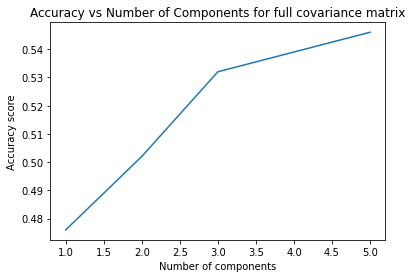

Youtube accuracy for number of comps 1 is 0.081 for full type
Youtube accuracy for number of comps 2 is 0.084 for full type
Youtube accuracy for number of comps 3 is 0.081 for full type
Youtube accuracy for number of comps 4 is 0.08 for full type
Youtube accuracy for number of comps 5 is 0.082 for full type


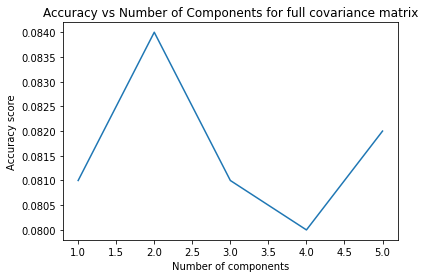

PrasarBharti accuracy for number of comps 1 is 0.33 for diag type
PrasarBharti accuracy for number of comps 2 is 0.339 for diag type
PrasarBharti accuracy for number of comps 3 is 0.349 for diag type
PrasarBharti accuracy for number of comps 4 is 0.362 for diag type
PrasarBharti accuracy for number of comps 5 is 0.373 for diag type


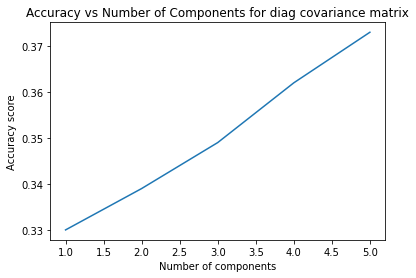

Youtube accuracy for number of comps 1 is 0.083 for diag type
Youtube accuracy for number of comps 2 is 0.091 for diag type
Youtube accuracy for number of comps 3 is 0.088 for diag type
Youtube accuracy for number of comps 4 is 0.087 for diag type
Youtube accuracy for number of comps 5 is 0.089 for diag type


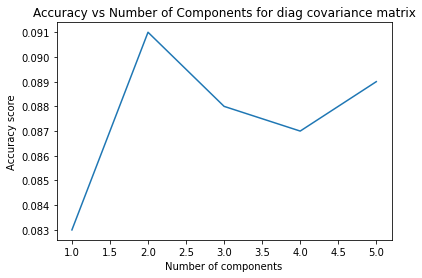

In [10]:
def prior_prob(class_train, train):
  return len(class_train)/len(train)

def predict(ll, pri, pred, i):
  prob = []
  for k in range(12):
      prob.append(ll[k][i] * pri[k])
  return np.argmax(prob)


test = [pb_test,yt_test]
test_label = [pb_test['class'], yt_test['class']]
for type_of_covariance_matrix in ['full', 'diag']:
  for t in range(len(test)):
    gmm_accuracies=[]
    for comp in range(1,6):
      gmm, ll, pri = [], [], []
      for i in range(0,12):
        class_train = train[train['class']==i].drop(['class'],axis=1)
        pri.append(prior_prob(class_train, train))
        gmm_class = GaussianMixture(n_components=comp, covariance_type=type_of_covariance_matrix).fit(class_train)
        gmm.append(gmm_class)
        ll.append(np.exp(gmm_class.score_samples(test[t].drop(['class'],axis=1))))

      pred=[]
      for i in range(len(test[t].drop(['class'],axis=1))):
            pred.append(predict(ll, pri, pred, i))
            
      gmm_accuracies.append(np.round(accuracy_score(test_label[t],pred),3)) #storing accuracies for graph
      if(t==0):
        print(f"PrasarBharti accuracy for number of comps {comp} is {np.round(accuracy_score(test_label[t],pred),3)} for {type_of_covariance_matrix} type")
      else:
        print(f"Youtube accuracy for number of comps {comp} is {np.round(accuracy_score(test_label[t],pred),3)} for {type_of_covariance_matrix} type")
    components = [i for i in range(1,6)]
    plt.xlabel('Number of components')
    plt.ylabel('Accuracy score')
    plt.plot(components, gmm_accuracies)
    plt.title(f"Accuracy vs Number of Components for {type_of_covariance_matrix} covariance matrix")
    plt.show()

PrasarBharti accuracy for number of comps 1 is 0.401 for full type
Confusion Matrix: [[13311  4044  4531  1076   540  2438  3281  2405  4552  1922  1594  2021]
 [ 2800 27850   802  1305   256   772  2561  1121  2961   915  1803   408]
 [ 3922   469 17695   117   468  3897  3725  3067  3220   525  1890  3038]
 [  341   317   956 28722  3142  1621   448   931   520  4856  1933  2825]
 [ 1373  1674  2739 10857  4350  3338   897  4454  1973  6590  2974  1912]
 [ 1649  2712  3433  2104  1677 19072  1523  1301  2349  2164  2220  2645]
 [ 3051  2724  2446  1461   387  1164 14506  2320  5135   595  3346  1761]
 [ 4490   615  1910   498   645   508  1225 18737  2090  2148  1791  1406]
 [ 4414  3424  4065  1067   688  2727  1271  2247 18187  1580  2467  1665]
 [  134   316   126 22462  2677  1083    33   635   508 19796  1116   703]
 [  536  4249   445  4787  1692  2219  1135   894  2114  1703 19286  4631]
 [ 3039  1722  6068  7119  1767  5393  2863  2243  2703  2827  4760  6656]]
PrasarBharti a

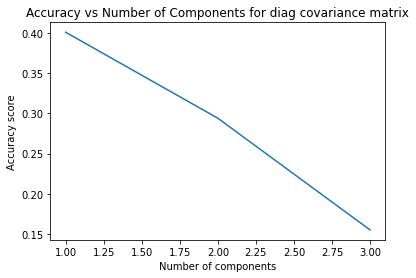

Youtube accuracy for number of comps is 1 is 0.073 for full type
Confusion Matrix: [[ 8862  8626  5140   207    64  1695  2849  5468  3059   586   522  1040]
 [ 4531  5220  6749   125   123  1204  5999  5794  2919   265  1085   580]
 [ 5085 10906  3376    71   380  2722  7070  3174  2368   250  3335  1180]
 [ 2242  2856  3667   350   589  2182 10626  8405  1232   821  3582  2175]
 [ 5635  8959  1481    13    40  6915  5846  3927  4007   453  1116   903]
 [ 6928  5036  5155   109   107  1696  3980  9388  3061   550   363  1085]
 [ 2332 10864   927  2224   709  1564  3083  7210  3055  2391  3222  1338]
 [ 5657 13542  3177    61   186  1393  6186  3724  2186   567   944  2200]
 [ 6158  5775  5437   124   108   862  2407 12473  2803   331  1282   791]
 [ 4782  1366  4052    39    80   260  2066 12425  8921   262   976   995]
 [ 2545  6452   452  3008   735   694  1836  9172  2626  5550  1840  1427]
 [ 2983  6380  2156  1077  1289  2100  4615  9930  1753  2078  3825  2239]]
Youtube accuracy

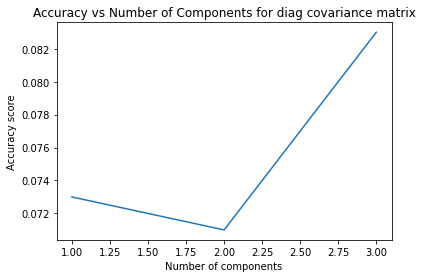

PrasarBharti accuracy for number of comps 1 is 0.303 for diag type
Confusion Matrix: [[ 8342  3713  7022  1731   262  4232   976  3527  3863  2458  3393  2196]
 [ 3134 20392  1912  2218   127  2043  1129  2231  3820  1230  4469   849]
 [ 3422   602 15178   726   312  6429   950  3193  3037  1309  3333  3542]
 [ 1154   592  2560 23757  1570  2835   167  1320  1048  6702  3271  1636]
 [ 2172  1522  4279 10480  1752  4732   281  4150  2184  6413  3663  1503]
 [ 1165  2073  5958  2603   861 16067   546  1928  2442  2453  4246  2507]
 [ 2509  2425  4059  2949   255  2839  5916  4621  4204  1299  5596  2224]
 [ 4398   972  3990  1253   143   970   399 16241  1855  2925  1928   989]
 [ 3576  3221  7009  1082   299  3567   503  2550 14613  1388  3965  2029]
 [ 1332   803  2558 19153  1260  3204    51  1940  1475 14573  2499   741]
 [  801  4242  2095  6198   603  5019   538  1566  2255  1918 16154  2302]
 [ 2122  1741  5867  8536  1084  6638  1245  3320  2403  3584  6382  4238]]
PrasarBharti a

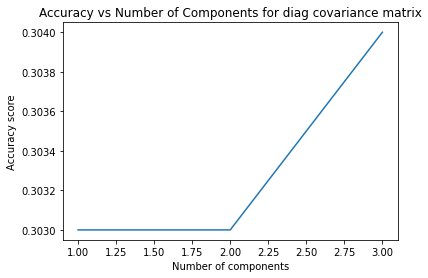

Youtube accuracy for number of comps is 1 is 0.08 for diag type
Confusion Matrix: [[ 5571  7005  6345   713    98  3148  1671  4562  4125   665  2498  1717]
 [ 3389  4819  7374   493    31  3339  2808  4778  3279   380  2692  1212]
 [ 2764  8789  4327   741   175  4321  2466  3008  3534   506  7248  2038]
 [ 1664  3023  4631  2649   220  3554  5453  5911  1792   788  5612  3430]
 [ 3525  6140  2963  1330    24  7939  2095  3625  3965  1066  4006  2617]
 [ 3421  4943  6033   583    67  3173  1832  7528  4016   815  2416  2631]
 [ 2334  7613  2482  3860   264  2279  2086  6072  3342  1862  5169  1556]
 [ 3823 10715  4067   468    67  3763  4870  3661  2489   760  2914  2226]
 [ 5838  4767  5322   610    82  1848  1132  9350  3989   712  2829  2072]
 [ 3894  2023  6828   427   123   680  1199  9287  7801   639  1718  1605]
 [ 2821  4962  1384  5639   594   928  1178  8182  2677  3341  3122  1509]
 [ 2346  4750  3847  3928   447  2318  2205  8112  2150  2509  5148  2665]]
Youtube accuracy 

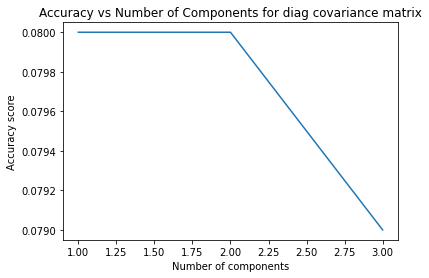

In [18]:
def prior_prob(class_train, train):
  return len(class_train)/len(train)

def predict(ll, pri, pred, i):
  prob = []
  for k in range(12):
      prob.append(ll[k][i] * pri[k])
  return np.argmax(prob)


test = [pb_test,yt_test]
test_label = [pb_test['class'], yt_test['class']]
for cov_type in ['full', 'diag']:
  for t in range(len(test)):
    ubm_accuracies=[]
    relevance_factor = 0.7
    for q in range(1, 4):
      ubm, ll, pri = [], [], []
      for i in range(0,12):
        UBM = GaussianMixture(n_components=q, covariance_type=cov_type)
        UBM.fit(train.drop(['class'],axis=1))
        class_train = train[train['class']==i].drop(['class'],axis=1)
        pri.append(len(class_train)/len(train))
        mu_k_hat = (len(class_train)/(len(class_train) + relevance_factor)) * class_train.mean().values + (1 - (len(class_train)/(len(class_train) + relevance_factor))) * UBM.means_[0]
        UBM.means_ = np.array([mu_k_hat])
        ubm.append(UBM)
        ll.append(np.exp(UBM.score_samples(test[t].drop(['class'],axis=1))))

      pred=[]
      for i in range(len(test[t].drop(['class'],axis=1))):
            pred.append(predict(ll, pri, pred, i))

      ubm_accuracies.append(np.round(accuracy_score(test_label[t], pred),3))
      if(t==0):
        print(f"PrasarBharti accuracy for number of comps {q} is {np.round(accuracy_score(test_label[t], pred),3)} for {cov_type} type")
      else:
        print(f"Youtube accuracy for number of comps is {q} is {np.round(accuracy_score(test_label[t], pred),3)} for {cov_type} type")
      print("Confusion Matrix:",  confusion_matrix(test_label[t], pred))
    components = [i for i in range(1, 4)]
    plt.xlabel('Number of components')
    plt.ylabel('Accuracy score')
    plt.plot(components,ubm_accuracies)
    plt.title(f"Accuracy vs Number of Components for {type_of_covariance_matrix} covariance matrix")
    plt.show()